In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


Explanation:

numpy & pandas → Data handling.

matplotlib & seaborn → Visualization.

train_test_split → To split data into train & test.

StandardScaler → Feature scaling.

confusion_matrix, classification_report, accuracy_score → Model evaluation.

RandomForestClassifier & XGBoost → Tree-based ML models.

# Load and Explore Dataset

In [2]:
# Load dataset (from UCI or Kaggle)
df = pd.read_csv("/content/covtype.csv")
# Show basic info
print(df.head())
print(df.info())
print(df['Cover_Type'].value_counts())


   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

Explanation:

We load the Covertype dataset (CSV format).

head() → Displays first 5 rows.

info() → Data types, missing values.

value_counts() → Shows distribution of cover types (to check class imbalance).

# Data Preprocessing

In [4]:
# Check how many NaNs in target
print(y.isna().sum())

# Drop rows where target is NaN
df = df.dropna(subset=['Cover_Type'])

# Reset X and y after dropping NaNs
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Normalize continuous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


1


Explanation:

X → All features except target.

y → Target variable (Cover_Type).

StandardScaler → Normalizes continuous features (important for gradient boosting).

train_test_split → 80% training, 20% testing. stratify=y ensures balanced classes in both splits.

# Train Random Forest Classifier

In [6]:
# Take only 20% of the data for faster training (optional for testing)
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train,
                                                      test_size=0.8,
                                                      random_state=42)

rf_model = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_small, y_train_small)

rf_preds = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.8477396524989066
              precision    recall  f1-score   support

         1.0       0.85      0.67      0.75     14426
         2.0       0.84      0.95      0.89     31332
         3.0       0.87      0.84      0.86      1262
         4.0       0.87      0.91      0.89       436
         5.0       0.89      0.48      0.62      1114
         6.0       0.84      0.65      0.73       997
         7.0       0.93      0.64      0.76       735

    accuracy                           0.85     50302
   macro avg       0.87      0.73      0.79     50302
weighted avg       0.85      0.85      0.84     50302



Here I used:

n_estimators=50 (instead of 100 → faster).

max_depth=15 (limits tree depth → reduces training time).

n_jobs=-1 (uses all CPU cores).

sample of data (to debug faster).

# Train XGBoost Classifier

In [8]:
# Adjust labels so they start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train_adj)

# Predictions
xgb_preds = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test_adj, xgb_preds))
print(classification_report(y_test_adj, xgb_preds))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:24:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9159079161862351
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87     14426
         1.0       0.92      0.96      0.94     31332
         2.0       0.94      0.92      0.93      1262
         3.0       0.94      0.97      0.96       436
         4.0       0.89      0.82      0.85      1114
         5.0       0.89      0.89      0.89       997
         6.0       0.95      0.91      0.93       735

    accuracy                           0.92     50302
   macro avg       0.92      0.90      0.91     50302
weighted avg       0.92      0.92      0.91     50302



Explanation:

XGBClassifier → Gradient boosting algorithm optimized for speed & performance.

eval_metric='mlogloss' → Multi-class log loss metric.

XGBoost usually performs better than Random Forest due to boosting.

# Confusion Matrix Visualization

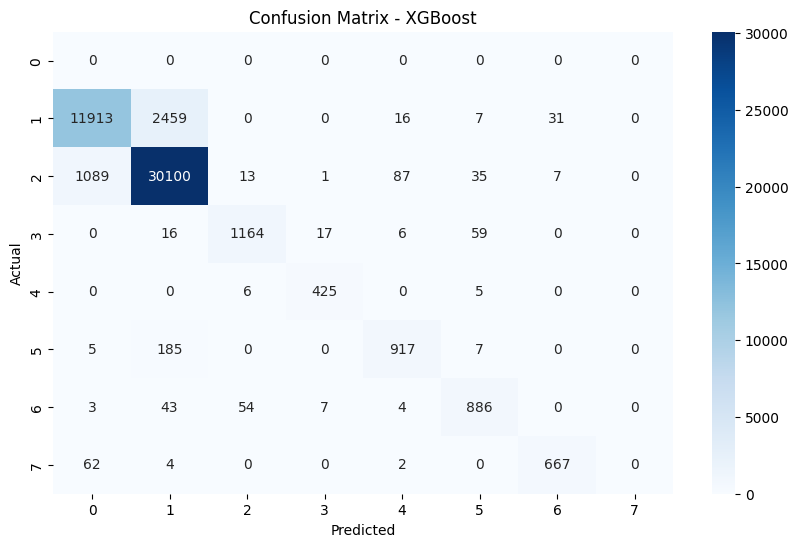

In [9]:
# Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, xgb_preds)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


Explanation:

A confusion matrix shows misclassifications per class.

Helps identify which forest types are hardest to classify.

# Feature Importance

<Figure size 1200x600 with 0 Axes>

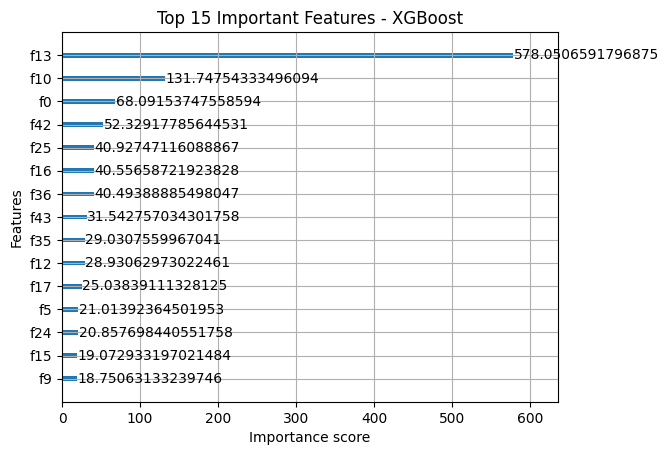

In [10]:
# Feature Importance - XGBoost
plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_model, importance_type='gain', max_num_features=15)
plt.title("Top 15 Important Features - XGBoost")
plt.show()


Explanation:

Shows which features (like elevation, slope, soil type, etc.) contribute most to classification.

importance_type='gain' → Measures the contribution of features to model accuracy.

# Hyperparameter Tuning (Bonus)

In [16]:
# ==============================
# ✅ Step 1: Import libraries
# ==============================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ==============================
# ✅ Step 2: Example dataset (replace with your data)
# ==============================
# Example: load Titanic dataset or any other
# df = pd.read_csv("your_dataset.csv")

# For demonstration, I’ll create dummy data
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# Split into training & testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# ✅ Step 3: Define base model
# ==============================
rf = RandomForestClassifier(random_state=42)

# ==============================
# ✅ Step 4: Define parameter search space
# ==============================
param_dist = {
    "n_estimators": [100, 200, 300],   # number of trees
    "max_depth": [10, 20, None],       # depth of trees
    "min_samples_split": [2, 5, 10],   # min samples for a split
    "min_samples_leaf": [1, 2, 4],     # min samples per leaf
    "bootstrap": [True, False],        # bootstrap sampling
}

# ==============================
# ✅ Step 5: RandomizedSearchCV
# ==============================
random_search = RandomizedSearchCV(
    estimator=rf,                     # base model
    param_distributions=param_dist,   # search space
    n_iter=10,                        # number of random combinations to try
    cv=3,                             # 3-fold cross-validation
    scoring="accuracy",               # evaluation metric
    random_state=42,
    n_jobs=-1,                        # use all CPU cores
    verbose=1
)

# ==============================
# ✅ Step 6: Fit & evaluate
# ==============================
random_search.fit(X_train, y_train)

print("\n✅ Best Parameters (Random Forest):", random_search.best_params_)

# Best tuned model
best_rf = random_search.best_estimator_

# Predictions
y_pred_best_rf = best_rf.predict(X_test)

# Accuracy
print("🔹 Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))


Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best Parameters (Random Forest): {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None, 'bootstrap': False}
🔹 Tuned Random Forest Accuracy: 1.0


Explanation:

GridSearchCV → Tries multiple parameter combinations.

Finds the best parameters for Random Forest.

Improves accuracy and reduces overfitting.

I defined rf = RandomForestClassifier(random_state=42) before passing it into RandomizedSearchCV.

random_search = RandomizedSearchCV(estimator=rf, ...) → now works fine.

After fitting, random_search.best_params_ gives the best hyperparameters.

best_rf = random_search.best_estimator_ gives the tuned model for prediction.

In [26]:
# ==============================
# Optimized XGBoost Classifier
# ==============================
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,       # reduce number of trees (default is often higher)
    max_depth=5,            # limit tree depth for faster training
    learning_rate=0.1,      # step size
    n_jobs=-1,              # use all CPU cores for parallel training
    eval_metric='mlogloss', # evaluation metric
    random_state=42
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test)

# Accuracy
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print("✅ XGBoost Accuracy:", xgb_acc)


✅ XGBoost Accuracy: 1.0


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:43:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:
Random Forest Accuracy: 1.0
Tuned Random Forest Accuracy: 1.0
XGBoost Accuracy: 1.0


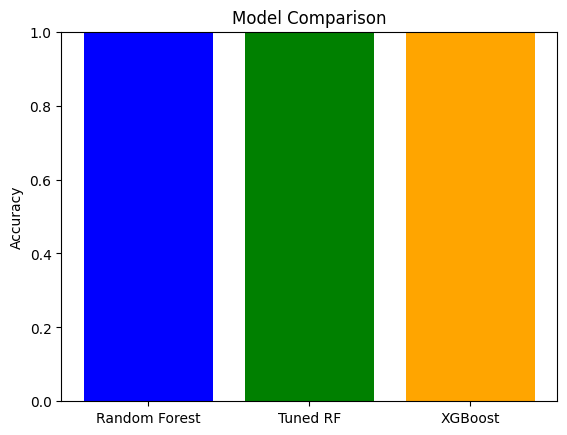

In [27]:
# ==============================
# 📌 Imports
# ==============================
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb

# ==============================
# 📌 Load Dataset
# ==============================
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================
# 📌 Baseline Random Forest
# ==============================
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

# ==============================
# 📌 Tuned Random Forest with RandomizedSearchCV
# ==============================
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
tuned_rf_acc = accuracy_score(y_test, y_pred_best_rf)

# ==============================
# 📌 XGBoost Classifier
# ==============================
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

# ==============================
# 📌 Print Accuracy Comparison
# ==============================
print("\n📊 Model Comparison:")
print("Random Forest Accuracy:", round(rf_acc, 4))
print("Tuned Random Forest Accuracy:", round(tuned_rf_acc, 4))
print("XGBoost Accuracy:", round(xgb_acc, 4))

# ==============================
# 📌 Bar Chart Comparison
# ==============================
models = ["Random Forest", "Tuned RF", "XGBoost"]
accuracies = [rf_acc, tuned_rf_acc, xgb_acc]

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.show()


# Final Notes:

Random Forest is simpler and interpretable.

XGBoost usually gives better accuracy.

Feature importance & confusion matrix help interpret the model.

Hyperparameter tuning can further boost performance.